In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.parse import CoreNLPParser

from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt
import stanza
from stanza.server import CoreNLPClient
import os


c:\Users\kevin\anaconda3\envs\TEXTMING\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# W3 Data Clean

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Read Data

In [14]:
trueDataframe = pd.read_csv('True.csv')
fakeDataframe = pd.read_csv('Fake.csv')
trueDataframe['type'] = 'true'
fakeDataframe['type'] = 'fake'
df = pd.concat([trueDataframe, fakeDataframe])
df

,title,text,subject,date,type
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",fake
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",fake
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",fake
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",fake


斷句

In [15]:
sentenceTokoenized = df.assign(sentence = df['text'].apply(nltk.sent_tokenize)).explode('sentence').drop(['text'], axis=1)
display(sentenceTokoenized.head(5))

,title,subject,date,type,sentence
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON (Reuters) - The head of a conservat...
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,In keeping with a sharp pivot under way among ...
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,When they return from the holidays on Wednesda...
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,President Donald Trump and his Republicans wan...
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,“The (Trump) administration has already been w...


Data Clean & 斷詞

In [16]:
sentenceTokoenized["sentence"] = sentenceTokoenized["sentence"].astype(str).apply(lambda x: re.sub(r'[^\w\s]','', x))  #只留下英文字母和空格(包含換行符號)
sentenceTokoenized["sentence"] = sentenceTokoenized["sentence"].astype(str).apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格
sentenceTokoenized = sentenceTokoenized[~sentenceTokoenized["sentence"].str.len() < 1]
wordTokoenized = sentenceTokoenized.assign(token = sentenceTokoenized['sentence'].apply(nltk.word_tokenize)).explode('token')
wordTokoenized = wordTokoenized[~(wordTokoenized["token"].astype(str).str.len() <= 1)]
wordTokoenized.reset_index(inplace=True, drop=True)

Lower Case

In [17]:
lowerWord = wordTokoenized.assign(word = wordTokoenized['token'].str.lower())

Stem

In [18]:
porter = PorterStemmer()
lowerWord['word'] = lowerWord['word'].astype(str)
stem_df = lowerWord.assign(stem = lowerWord['word'].apply(porter.stem)).reset_index(drop=True)

stem_df

,title,subject,date,type,sentence,token,word,stem
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,WASHINGTON,washington,washington
1,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,Reuters,reuters,reuter
2,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,The,the,the
3,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,head,head,head
4,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,of,of,of
...,...,...,...,...,...,...,...,...
17420396,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,21st,21st,21st
17420397,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,Century,century,centuri
17420398,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,Wire,wire,wire
17420399,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,Iran,iran,iran


Lemma

In [19]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
lemma_df = stem_df.assign(lemma = stem_df["stem"].apply(lemmatizer.lemmatize))
lemma_df

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,title,subject,date,type,sentence,token,word,stem,lemma
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,WASHINGTON,washington,washington,washington
1,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,Reuters,reuters,reuter,reuter
2,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,The,the,the,the
3,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,head,head,head,head
4,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,of,of,of,of
...,...,...,...,...,...,...,...,...,...
17420396,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,21st,21st,21st,21st
17420397,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,Century,century,centuri,centuri
17420398,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,Wire,wire,wire,wire
17420399,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,Iran,iran,iran,iran


停用字

In [20]:
nltk.download('stopwords')
stops = stopwords.words('english')
noStop_df = lemma_df[~lemma_df['lemma'].isin(stops)]
with open("stopwords.txt", "r") as file:
    stopwordList = file.readlines()
stopwordList = [word.strip() for word in stopwordList]

noStop_df = noStop_df[~lemma_df['lemma'].isin(stopwordList)]
noStop_df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\kevin\AppData\Local\Temp\ipykernel_10492\2405022972.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  noStop_df = noStop_df[~lemma_df['lemma'].isin(stopwordList)]


,title,subject,date,type,sentence,token,word,stem,lemma
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,WASHINGTON,washington,washington,washington
1,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,Reuters,reuters,reuter,reuter
3,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,head,head,head,head
5,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,conservative,conservative,conserv,conserv
6,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",true,WASHINGTON Reuters The head of a conservative...,Republican,republican,republican,republican
...,...,...,...,...,...,...,...,...,...
17420396,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,21st,21st,21st,21st
17420397,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,Century,century,centuri,centuri
17420398,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,Wire,wire,wire,wire
17420399,10 U.S. Navy Sailors Held by Iranian Military ...,Middle-east,"January 12, 2016",fake,Clearly this looks like a neocon stuntStay tun...,Iran,iran,iran,iran


計算詞頻

In [21]:
freq_df = pd.DataFrame(noStop_df['lemma'].value_counts()).reset_index()
freq_df.columns = ['word', 'freq']
freq_df.head(15)

,word,freq
0,trump,128213
1,state,60318
2,presid,56254
3,peopl,41367
4,republican,38123
5,year,33524
6,new,30928
7,govern,29663
8,like,29443
9,hous,29006


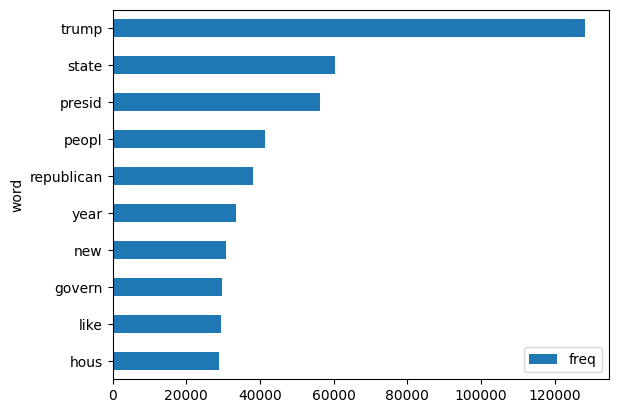

In [22]:
freq_df.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

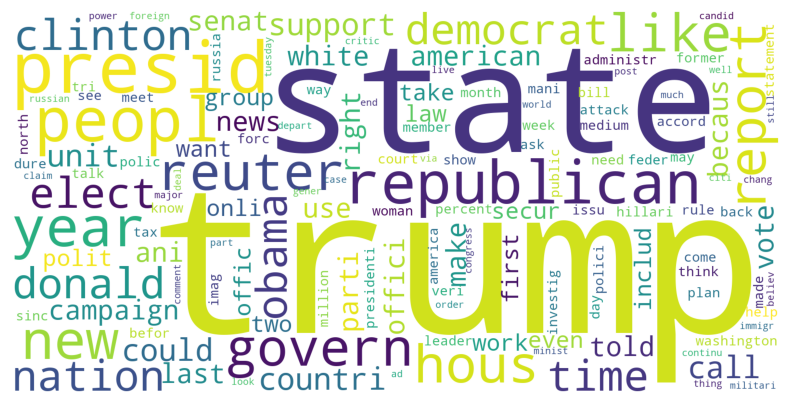

In [23]:
text = freq_df.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=200).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# W4 情緒分析

In [24]:
dataset_df = noStop_df.copy()

en_dict_path = "./liwc/LIWC_EN.csv"
liwc_dict = pd.read_csv(en_dict_path)
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

dataset_liwc_df = pd.merge(dataset_df, liwc_dict, how = 'left')
dataset_liwc_df = dataset_liwc_df.dropna(subset=['sentiments']).reset_index(drop=True)

sentiment_count = pd.DataFrame(dataset_liwc_df.groupby(['type', 'sentiments']).size().reset_index())

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: 'size'})
sentiment_count

,type,sentiments,size
3,fake,negative,134382
4,fake,positive,168705
9,true,negative,77473
10,true,positive,118871


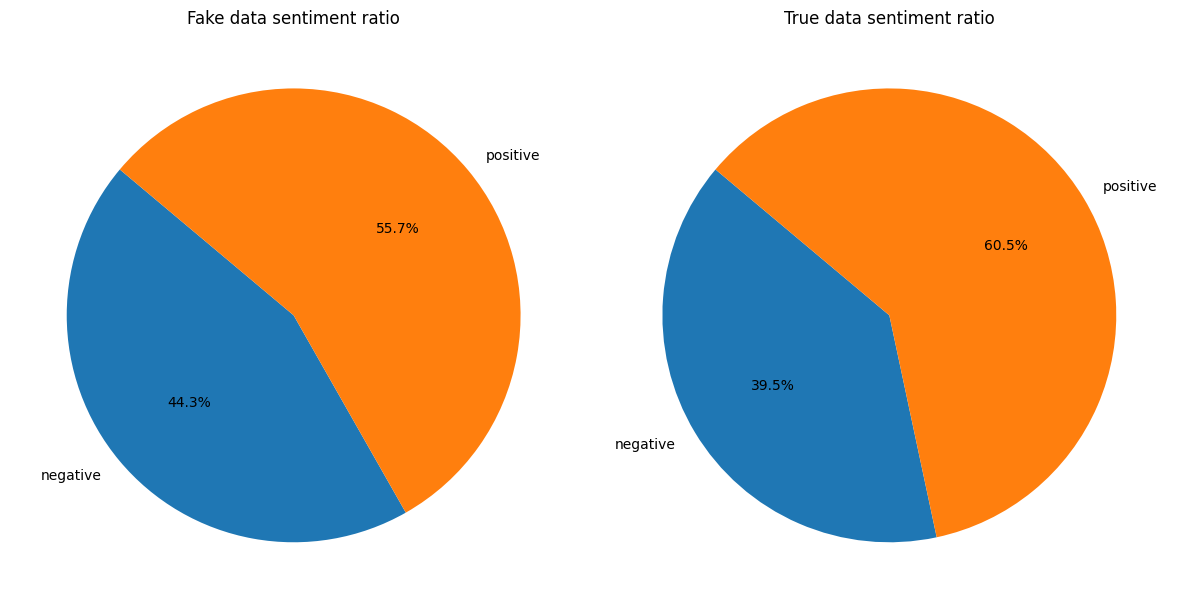

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Fake data sentiment ratio
labels = ['negative', 'positive']
sizes_fake = [sentiment_count.iloc[0]['size'], sentiment_count.iloc[1]['size']]
axes[0].pie(sizes_fake, labels=labels, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Fake data sentiment ratio')

# True data sentiment ratio
sizes_true = [sentiment_count.iloc[2]['size'], sentiment_count.iloc[3]['size']]
axes[1].pie(sizes_true, labels=labels, autopct='%1.1f%%', startangle=140)
axes[1].set_title('True data sentiment ratio')

plt.tight_layout()
plt.show()

# W5 senti 2 ( CoreNLP )

安裝Core NLP

In [3]:
stanza.install_corenlp("./stanza_corenlp") # 下載coreNLP模型，預設會在/stanza_corenlp裡面
os.environ['CORENLP_HOME'] = "./stanza_corenlp" # 因為自訂下載路徑，所以要設定環境參數
# 設定 CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9999
client = CoreNLPClient(
            # client要處理的項目
            annotators=['tokenize','ssplit','pos','lemma','ner','entitymentions', 'parse', 'sentiment'],     
            memory='4G', 
            endpoint='http://localhost:9999',
            # If set to False, the server process will print detailed error logs
            be_quiet=True
        )
client.start()
import time;
time.sleep(5)

2024-05-10 09:26:33 WARNING: Directory ./stanza_corenlp already exists. Please install CoreNLP to a new directory.
2024-05-10 09:26:33 INFO: Writing properties to tmp file: corenlp_server-a6b5568fd7064a94.props
2024-05-10 09:26:33 INFO: Starting server with command: java -Xmx4G -cp ./stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9999 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a6b5568fd7064a94.props -annotators tokenize,ssplit,pos,lemma,ner,entitymentions,parse,sentiment -preload -outputFormat serialized


測試

In [4]:
text = 'Try this: Make united states united again. For more info of Stanford CoreNLP Server, please visit www.khalidalnajjar.com for more details'
document = client.annotate(text)
print(type(document))

<class 'CoreNLP_pb2.Document'>


Core NLP 透過幾行code就可以實現斷詞、詞性標註、詞型還原、命名實體辨識

In [5]:
print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}\n{'-' * 50}")  
for i, sent in enumerate(document.sentence): 
    for t in sent.token:
        print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))
    print("")

Word        	Lemma       	POS   	NER
--------------------------------------------------
Try         	try         	VB    	O
this        	this        	DT    	O
:           	:           	:     	O
Make        	make        	VB    	O
united      	united      	JJ    	COUNTRY
states      	state       	NNS   	COUNTRY
united      	unite       	VBD   	O
again       	again       	RB    	O
.           	.           	.     	O

For         	for         	IN    	O
more        	more        	JJR   	O
info        	info        	NN    	O
of          	of          	IN    	O
Stanford    	Stanford    	NNP   	O
CoreNLP     	corenlp     	NN    	O
Server      	server      	NN    	O
,           	,           	,     	O
please      	please      	UH    	O
visit       	visit       	VB    	O
www.khalidalnajjar.com	www.khalidalnajjar.com	ADD   	URL
for         	for         	IN    	O
more        	more        	JJR   	O
details     	detail      	NNS   	O



在NER的部分，有時候會出現人名、地名是名詞詞組，除了上面用單詞標註的ner，我們可以利用entitymentions把名詞詞組拿出來

In [7]:
for i, sent in enumerate(document.sentence): 
    print(f"{'Words':12s}\t{'NER'}\n{'-' * 50}")
    for mention in sent.mentions:
        print(mention.entityMentionText, "為!", mention.ner)
    s = ""
    for t in sent.token: 
        s = s + t.word + " "
    print(f"sentence{i}: {s}\n")

Words       	NER
--------------------------------------------------
united states 為! COUNTRY
sentence0: Try this : Make united states united again . 

Words       	NER
--------------------------------------------------
www.khalidalnajjar.com 為! URL
sentence1: For more info of Stanford CoreNLP Server , please visit www.khalidalnajjar.com for more details 



POS 小補充
同樣的詞可能會因為詞義不同而有不同的詞性，以下舉her這個詞為例，在第一句代替「她」這個人，所以是PRP，在第二句則是指「她的」所以分類為PRP$

「her」的 POS 分類
PRP:人稱代名詞(personal pronoun)，其他如 I, he, she
PRP$: 所有代名詞(possessive pronoun)，其他如 my, his, hers

In [13]:
text = 'I didn\'t tell her. Do you know her name?'
document = client.annotate(text)
# TODO: 不知道sent跟t的差別是甚麼 好像都是印出一樣的東西
for i, sent in enumerate(document.sentence): 
    for t in sent.token:
        print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))
    print("")
# PRP 反身代名詞?
# PRP$ 所有格代名詞?
# VBD 過去式動詞

I           	I           	PRP   	O
did         	do          	VBD   	O
n't         	not         	RB    	O
tell        	tell        	VB    	O
her         	she         	PRP   	O
.           	.           	.     	O

Do          	do          	VBP   	O
you         	you         	PRP   	O
know        	know        	VB    	O
her         	she         	PRP$  	O
name        	name        	NN    	O
?           	?           	.     	O



利用coreNLP進行情緒標註(Sentiment)

In [18]:
document = client.annotate("I love this cheese sandwich, it’s so delicious. This chicken burger has a very bad taste")
print(f"{'Word':12s}\t{'Sentiment':12s}\n{'-' * 50}")

for i, sent in enumerate(document.sentence):
    for t in sent.token:
        # t是token
        # t.word取用字詞
        # t.sentiment取用情緒
        print("{:12s}\t{:12s}".format(t.word,t.sentiment))
    print(f"The sentiment of the {i}-th sentence is： {sent.sentiment}\n{'-' * 50}")

Word        	Sentiment   
--------------------------------------------------
I           	Neutral     
love        	Very positive
this        	Neutral     
cheese      	Neutral     
sandwich    	Neutral     
,           	Neutral     
it          	Neutral     
’s          	Neutral     
so          	Neutral     
delicious   	Positive    
.           	Neutral     
The sentiment of the 0-th sentence is： Positive
--------------------------------------------------
This        	Neutral     
chicken     	Neutral     
burger      	Neutral     
has         	Neutral     
a           	Neutral     
very        	Neutral     
bad         	Very negative
taste       	Neutral     
The sentiment of the 1-th sentence is： Very negative
--------------------------------------------------


In [19]:
# 最後再把背景的client關掉
client.stop()

### 3. CoreNLP 標註